Berceley Deep RL course. Fall 2017
http://rll.berkeley.edu/deeprlcourse/
Homework 1

## Section 4.  DAgger
1.  Implement DAgger.  See the code provided in
run
expert.py
to see how to query the expert policy
and perform roll-outs in the environment.
2.  Run DAgger and report results on one task in which DAgger can learn a better policy than behavioral
cloning.  Report your results in the form of a learning curve, plotting the number of DAgger iterations
vs.  the policy’s mean return, with error bars to show the standard deviation.  Include the performance
of the expert policy and the behavioral cloning agent on the same plot.  In the caption, state which
task you used, and any details regarding network architecture, amount of data, etc.  (as in the previous
section).

In [1]:
import gym

import pickle
import time
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline



### Feed forward nn

In [2]:
class FFN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate = 0.3):
        super(FFN, self).__init__()
        self.dropout_rate = dropout_rate
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.drop1  = nn.Dropout(p = self.dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.drop2  = nn.Dropout(p = self.dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, hidden_size2)
        self.drop3  = nn.Dropout(p = self.dropout_rate)
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = F.relu(self.fc3(x))
        x = self.drop3(x)
        x = self.fc4(x)
        return x.view(x.size(0), -1)
    
    def set_dropout_rate(self, p):
        self.dropout_rate = p
        


In [3]:
criterion = torch.nn.L1Loss()

# Training function
def train_ffn(states_tensor, actions_tensor,learning_rate):
    tmp_loss = 0
    
    ffn.zero_grad()

    output = ffn(states_tensor)               # Predict action
    loss = criterion(output, actions_tensor)  # Calculate error
    tmp_loss += loss.data[0]
    loss.backward()                              # Error backpropagation

    for p in ffn.parameters():                   # Update net's parameters
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, tmp_loss 

In [4]:
def get_expert_data(args,policy_fn):
    with tf.Session():
        tf_util.initialize()

        env = gym.make(args.envname)
        max_steps = args.max_timesteps or env.spec.timestep_limit

        returns = []
        observations = []
        actions = []
        for i in range(args.num_rollouts):
#             print('iter', i)
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                action = policy_fn(obs[None,:])
                observations.append(obs)
                actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                if args.render:
                    env.render()
                #if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
                if steps >= max_steps:
                    break
            returns.append(totalr)

#         print('returns', returns)
#         print('mean return', np.mean(returns))
#         print('std of return', np.std(returns))

        expert_data = {'observations': np.array(observations),
                       'actions': np.array(actions)}
    
    return expert_data, returns

def get_expert_actions(policy_fn,observations):
    return policy_fn(np.array(observations))


#Evaluate learned policy
def run_agent(ffn, args):
    dropout_rate = ffn.dropout_rate
    ffn.dropout_rate = 0
    env = gym.make(args.envname)
    max_steps = args.max_timesteps or env.spec.timestep_limit

    returns = []
    observations = []
    actions = []
    for i in range(args.num_rollouts):
        #print('iter', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = ffn(Variable(torch.Tensor(obs))).data.numpy()  
            observations.append(obs)
            actions.append(action)
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1

            if args.render:
                env.render()

            if steps >= max_steps:
                break
            
        #print(totalr)
        returns.append(totalr)

    data = {'observations': np.array(observations),
            'actions': np.array(actions)}
    ffn.dropout_rate = dropout_rate
    return data,returns


In [8]:
import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy
import pandas as pd

tf.logging.set_verbosity(tf.logging.ERROR)

def train_DAgger(ffn, args):
    
    minibatch_size = args.get('minibatch_size',16)
    train_size = args.get('train_size',50000)

#     print('loading and building expert policy')
    target_policy_fn = load_policy.load_policy(args.expert_policy_file)
#     print('loaded and built')
    
    with tf.Session():
        tf_util.initialize()

        # Get initial data    
        get_expert_data_args = args.copy()
        get_expert_data_args.num_rollouts = 10
        expert_data, expert_returns = get_expert_data(get_expert_data_args, target_policy_fn) 
        train_data = expert_data
        train_data['actions'] = train_data['actions'][:,0,:]
#         print('init',train_data['actions'].shape)
        env = gym.make(args.envname)
        max_steps = args.max_timesteps or env.spec.timestep_limit

        returns = []
        errors = []
#         observations = []
#         actions = []
        agent_args = args.copy()
        agent_args.num_rollouts = 3
        
        for i in range(args.num_rollouts):
            
            # Train on expert_data
            error = 0
            for _ in range(int(train_size / minibatch_size) + 1):
                idx = np.random.choice(len(train_data['observations']),minibatch_size)
                _, err = train_ffn(Variable(torch.Tensor(train_data['observations'][idx])), 
                                         Variable(torch.Tensor(np.array(train_data['actions'][idx]))),
                                         learning_rate
                                        )
                error += err
            error /= train_size
            errors.append(error)
            
            # Get agent tragectory
            agent_data, rollout_returns = run_agent(ffn, agent_args)
            returns = returns + rollout_returns
            
            #Get expert actions for agent trajectory observations and add it to train data
            expert_actions = get_expert_actions(target_policy_fn,agent_data['observations'])
            train_data['observations'] = np.concatenate((train_data['observations'],agent_data['observations']))
            train_data['actions'] = np.concatenate((train_data['actions'], expert_actions))
            print(args.envname, i, np.mean(rollout_returns),error)
    return returns,errors,expert_returns            
            
 

['HalfCheetah-v1']

### Train loop

In [33]:
learning_rate = 1e-5

#environments = 'Ant-v1 HalfCheetah-v1 Hopper-v1 Humanoid-v1 Reacher-v1 Walker2d-v1'.split(' ')
environments = 'HalfCheetah-v1'.split(' ')

# results = {}
for envname in environments:
    env = gym.make(envname)
    state_shape = env.observation_space.shape[0]
    actions_shape = env.action_space.shape[0]

    print('Starting {} environment. State space dim {}, action space dim {}.'.format(
        envname,
        state_shape,
        actions_shape)
         )

#     ffn = FFN(state_shape, 128, 128, 128,actions_shape,dropout_rate = 0)

    # Warm start
    ffn = results[envname]['agent']
    args = pd.Series({
            'expert_policy_file':'experts/' + envname + '.pkl',
            'envname': envname,
            'max_timesteps': None,
            'num_rollouts':90,
            'render': False
        })

    returns,errors,expert_returns = train_DAgger(ffn, args)
    
    print('''Environment {}. State space dim {}, action space dim {}.
        DAgger run on {} rollouts.
        Mean reward {:.3f}. Reward std {:.3f}.
        '''.format(
        envname,
        state_shape,
        actions_shape,
        args.num_rollouts,
        np.mean(returns[-20:]),
        np.std(returns[-20:])
    ))
    results[envname] = {'returns':returns,'errors':errors,'expert_returns':expert_returns, 'agent':ffn}
pickle.dump(results,open('DAgger_results.pck','wb'))


[2017-11-06 00:28:08,997] Making new env: HalfCheetah-v1


Starting HalfCheetah-v1 environment. State space dim 17, action space dim 6.


[2017-11-06 00:28:09,659] Making new env: HalfCheetah-v1


obs (1, 17) (1, 17)


[2017-11-06 00:28:18,554] Making new env: HalfCheetah-v1
[2017-11-06 00:28:28,989] Making new env: HalfCheetah-v1


HalfCheetah-v1 0 4144.97575774 0.0017327058980427682


[2017-11-06 00:28:42,377] Making new env: HalfCheetah-v1


HalfCheetah-v1 1 4143.48072728 0.0017091127828881144


[2017-11-06 00:28:55,530] Making new env: HalfCheetah-v1


HalfCheetah-v1 2 4032.53060973 0.0017256959444470704


[2017-11-06 00:29:09,919] Making new env: HalfCheetah-v1


HalfCheetah-v1 3 4041.16933895 0.001750327979903668


[2017-11-06 00:29:21,402] Making new env: HalfCheetah-v1


HalfCheetah-v1 4 4166.17499668 0.0017594815267995


[2017-11-06 00:29:34,436] Making new env: HalfCheetah-v1


HalfCheetah-v1 5 4180.17039432 0.0017530183991417289


[2017-11-06 00:29:46,876] Making new env: HalfCheetah-v1


HalfCheetah-v1 6 4186.4904567 0.0017444963607005776


[2017-11-06 00:29:57,718] Making new env: HalfCheetah-v1


HalfCheetah-v1 7 4149.65071829 0.0017209504523314535


[2017-11-06 00:30:08,290] Making new env: HalfCheetah-v1


HalfCheetah-v1 8 4093.45123161 0.0017198785378411412


[2017-11-06 00:30:20,409] Making new env: HalfCheetah-v1


HalfCheetah-v1 9 4171.03930998 0.0017151209168881178


[2017-11-06 00:30:32,958] Making new env: HalfCheetah-v1


HalfCheetah-v1 10 4159.63171606 0.0017121582912281155


[2017-11-06 00:30:45,725] Making new env: HalfCheetah-v1


HalfCheetah-v1 11 4204.95811422 0.0017103775416314603


[2017-11-06 00:30:56,568] Making new env: HalfCheetah-v1


HalfCheetah-v1 12 4043.30238367 0.0017087707130797208


[2017-11-06 00:31:08,866] Making new env: HalfCheetah-v1


HalfCheetah-v1 13 4178.28878025 0.0017124673439003527


[2017-11-06 00:31:19,633] Making new env: HalfCheetah-v1


HalfCheetah-v1 14 4125.9903828 0.001723959074653685


[2017-11-06 00:31:30,125] Making new env: HalfCheetah-v1


HalfCheetah-v1 15 4081.77863202 0.0017087823299504817


[2017-11-06 00:31:40,307] Making new env: HalfCheetah-v1


HalfCheetah-v1 16 4103.37210459 0.0017122877740301191


[2017-11-06 00:31:50,540] Making new env: HalfCheetah-v1


HalfCheetah-v1 17 4153.40493979 0.0017024449987336993


[2017-11-06 00:32:00,937] Making new env: HalfCheetah-v1


HalfCheetah-v1 18 4088.31750972 0.0017027025551721454


[2017-11-06 00:32:11,391] Making new env: HalfCheetah-v1


HalfCheetah-v1 19 4121.32630492 0.0017158291625604034


[2017-11-06 00:32:22,250] Making new env: HalfCheetah-v1


HalfCheetah-v1 20 4069.81561411 0.0017111000720784067


[2017-11-06 00:32:32,474] Making new env: HalfCheetah-v1


HalfCheetah-v1 21 4133.04314021 0.001719631543252617


[2017-11-06 00:32:42,657] Making new env: HalfCheetah-v1


HalfCheetah-v1 22 4114.45360989 0.0016985068765096366


[2017-11-06 00:32:53,146] Making new env: HalfCheetah-v1


HalfCheetah-v1 23 4109.1438018 0.0017186162011511624


[2017-11-06 00:33:07,215] Making new env: HalfCheetah-v1


HalfCheetah-v1 24 4073.24745053 0.0017010873997583985


[2017-11-06 00:33:35,645] Making new env: HalfCheetah-v1


HalfCheetah-v1 25 4220.20877063 0.0017186168046668172


[2017-11-06 00:34:04,126] Making new env: HalfCheetah-v1


HalfCheetah-v1 26 4197.83442911 0.0017095889136381447


[2017-11-06 00:34:28,796] Making new env: HalfCheetah-v1


HalfCheetah-v1 27 4146.4472182 0.001714705435540527


[2017-11-06 00:34:51,334] Making new env: HalfCheetah-v1


HalfCheetah-v1 28 4069.51883628 0.0017229108191095294


[2017-11-06 00:35:08,859] Making new env: HalfCheetah-v1


HalfCheetah-v1 29 4184.45339306 0.0017286551883257926


[2017-11-06 00:35:21,869] Making new env: HalfCheetah-v1


HalfCheetah-v1 30 4201.85804986 0.0017189797793142497


[2017-11-06 00:35:34,230] Making new env: HalfCheetah-v1


HalfCheetah-v1 31 4095.37128584 0.0017010258335992694


[2017-11-06 00:35:46,891] Making new env: HalfCheetah-v1


HalfCheetah-v1 32 4110.84460139 0.0017200551629066468


[2017-11-06 00:35:59,298] Making new env: HalfCheetah-v1


HalfCheetah-v1 33 4137.25904773 0.001726625647544861


[2017-11-06 00:36:12,041] Making new env: HalfCheetah-v1


HalfCheetah-v1 34 4124.93953918 0.0017176339328289032


[2017-11-06 00:36:24,706] Making new env: HalfCheetah-v1


HalfCheetah-v1 35 4085.20790382 0.0017126300500892103


[2017-11-06 00:36:37,540] Making new env: HalfCheetah-v1


HalfCheetah-v1 36 4149.15088628 0.001716387934833765


[2017-11-06 00:36:49,934] Making new env: HalfCheetah-v1


HalfCheetah-v1 37 4153.86115874 0.0017236166293546557


[2017-11-06 00:37:02,347] Making new env: HalfCheetah-v1


HalfCheetah-v1 38 4088.10996768 0.001709995786845684


[2017-11-06 00:37:14,657] Making new env: HalfCheetah-v1


HalfCheetah-v1 39 4052.19009704 0.001727390037793666


[2017-11-06 00:37:27,155] Making new env: HalfCheetah-v1


HalfCheetah-v1 40 4177.0465516 0.0017185091243498028


[2017-11-06 00:37:39,500] Making new env: HalfCheetah-v1


HalfCheetah-v1 41 4218.70433686 0.0017147887955605984


[2017-11-06 00:37:51,627] Making new env: HalfCheetah-v1


HalfCheetah-v1 42 4220.43937389 0.0017227036665193737


[2017-11-06 00:38:04,513] Making new env: HalfCheetah-v1


HalfCheetah-v1 43 4200.48212465 0.0017169769665412605


[2017-11-06 00:38:16,608] Making new env: HalfCheetah-v1


HalfCheetah-v1 44 4137.12126636 0.001702115062084049


[2017-11-06 00:38:30,114] Making new env: HalfCheetah-v1


HalfCheetah-v1 45 4122.88380095 0.0016976459321379662


[2017-11-06 00:38:42,777] Making new env: HalfCheetah-v1


HalfCheetah-v1 46 4174.51950183 0.0017226261919923128


[2017-11-06 00:38:55,683] Making new env: HalfCheetah-v1


HalfCheetah-v1 47 4036.73476693 0.0017045693364366888


[2017-11-06 00:39:09,788] Making new env: HalfCheetah-v1


HalfCheetah-v1 48 4124.30921119 0.001715825452003628


[2017-11-06 00:39:21,976] Making new env: HalfCheetah-v1


HalfCheetah-v1 49 4180.97730819 0.001703333463575691


[2017-11-06 00:39:34,081] Making new env: HalfCheetah-v1


HalfCheetah-v1 50 4138.90510764 0.0017055967849120498


[2017-11-06 00:39:46,990] Making new env: HalfCheetah-v1


HalfCheetah-v1 51 4118.40900797 0.0017174841381981968


[2017-11-06 00:39:59,042] Making new env: HalfCheetah-v1


HalfCheetah-v1 52 4028.55788606 0.0017004282051697372


[2017-11-06 00:40:11,935] Making new env: HalfCheetah-v1


HalfCheetah-v1 53 4145.8089288 0.001715144152250141


[2017-11-06 00:40:25,131] Making new env: HalfCheetah-v1


HalfCheetah-v1 54 4106.25450104 0.0017074180609360338


[2017-11-06 00:40:37,668] Making new env: HalfCheetah-v1


HalfCheetah-v1 55 4126.14988904 0.0017230039657466114


[2017-11-06 00:40:49,699] Making new env: HalfCheetah-v1


HalfCheetah-v1 56 4128.61979972 0.0017097992536798119


[2017-11-06 00:41:02,354] Making new env: HalfCheetah-v1


HalfCheetah-v1 57 4169.65475318 0.0017067460796609522


[2017-11-06 00:41:14,467] Making new env: HalfCheetah-v1


HalfCheetah-v1 58 4142.02453812 0.0017032781337201596


[2017-11-06 00:41:27,249] Making new env: HalfCheetah-v1


HalfCheetah-v1 59 4150.48878217 0.0017042180460877716


[2017-11-06 00:41:39,570] Making new env: HalfCheetah-v1


HalfCheetah-v1 60 4205.17295206 0.0017054678252339363


[2017-11-06 00:41:52,166] Making new env: HalfCheetah-v1


HalfCheetah-v1 61 4071.52835291 0.0017135017929598689


[2017-11-06 00:42:04,476] Making new env: HalfCheetah-v1


HalfCheetah-v1 62 4126.30182093 0.0017054657635837793


[2017-11-06 00:42:16,660] Making new env: HalfCheetah-v1


HalfCheetah-v1 63 4080.86087138 0.0017190889281406998


[2017-11-06 00:42:29,668] Making new env: HalfCheetah-v1


HalfCheetah-v1 64 4094.0547718 0.0017087242218852042


[2017-11-06 00:42:42,368] Making new env: HalfCheetah-v1


HalfCheetah-v1 65 4134.55829492 0.0017103280518949032


[2017-11-06 00:42:54,589] Making new env: HalfCheetah-v1


HalfCheetah-v1 66 4181.92427592 0.0017167312135919928


[2017-11-06 00:43:06,745] Making new env: HalfCheetah-v1


HalfCheetah-v1 67 4164.02803978 0.0017163441371917726


[2017-11-06 00:43:20,043] Making new env: HalfCheetah-v1


HalfCheetah-v1 68 4079.6915951 0.001710530187226832


[2017-11-06 00:43:32,427] Making new env: HalfCheetah-v1


HalfCheetah-v1 69 4095.71398606 0.0017172713277488947


[2017-11-06 00:43:44,814] Making new env: HalfCheetah-v1


HalfCheetah-v1 70 4109.43986546 0.0017082138031721116


[2017-11-06 00:43:56,867] Making new env: HalfCheetah-v1


HalfCheetah-v1 71 4124.86812173 0.0017056923901289701


[2017-11-06 00:44:09,539] Making new env: HalfCheetah-v1


HalfCheetah-v1 72 4217.7073264 0.001712951753437519


[2017-11-06 00:44:22,225] Making new env: HalfCheetah-v1


HalfCheetah-v1 73 4150.9414598 0.001709523898269981


[2017-11-06 00:44:34,744] Making new env: HalfCheetah-v1


HalfCheetah-v1 74 4065.68599622 0.001711558267660439


[2017-11-06 00:44:46,832] Making new env: HalfCheetah-v1


HalfCheetah-v1 75 4129.88211009 0.0017028834602609278


[2017-11-06 00:44:59,577] Making new env: HalfCheetah-v1


HalfCheetah-v1 76 4105.66613951 0.001707457326799631


[2017-11-06 00:45:12,150] Making new env: HalfCheetah-v1


HalfCheetah-v1 77 4109.49772347 0.0017159943640977144


[2017-11-06 00:45:24,765] Making new env: HalfCheetah-v1


HalfCheetah-v1 78 4154.42846133 0.001712064184397459


[2017-11-06 00:45:37,347] Making new env: HalfCheetah-v1


HalfCheetah-v1 79 4144.87609715 0.0017062006726674735


[2017-11-06 00:45:49,362] Making new env: HalfCheetah-v1


HalfCheetah-v1 80 4112.64361395 0.0017210432731360197


[2017-11-06 00:46:01,751] Making new env: HalfCheetah-v1


HalfCheetah-v1 81 4096.08192963 0.0017129263359680772


[2017-11-06 00:46:14,487] Making new env: HalfCheetah-v1


HalfCheetah-v1 82 4079.96101594 0.0017133629588969052


[2017-11-06 00:46:27,095] Making new env: HalfCheetah-v1


HalfCheetah-v1 83 4108.07062668 0.0017117648735642432


[2017-11-06 00:46:40,397] Making new env: HalfCheetah-v1


HalfCheetah-v1 84 4209.46454963 0.0017178942080773414


[2017-11-06 00:46:53,002] Making new env: HalfCheetah-v1


HalfCheetah-v1 85 4162.84889561 0.0017171331586688756


[2017-11-06 00:47:05,630] Making new env: HalfCheetah-v1


HalfCheetah-v1 86 4125.87304261 0.001706172175593674


[2017-11-06 00:47:18,002] Making new env: HalfCheetah-v1


HalfCheetah-v1 87 4185.11766982 0.0017115675884857775


[2017-11-06 00:47:30,415] Making new env: HalfCheetah-v1


HalfCheetah-v1 88 4164.06935211 0.001708624685704708


[2017-11-06 00:47:42,758] Making new env: HalfCheetah-v1


HalfCheetah-v1 89 4140.98411107 0.0017170936284027995
Environment HalfCheetah-v1. State space dim 17, action space dim 6.
        DAgger run on 90 rollouts.
        Mean reward 4161.147. Reward std 68.310.
        


In [34]:
for envname in environments:
    print('''Environment {}. State space dim {}, action space dim {}.
        DAgger run on {} rollouts.
        Mean reward {:.3f}. Reward std {:.3f}.
        Mean expert reward {:.3f}. Expert reward std {:.3f}.
        '''.format(
        envname,
        state_shape,
        actions_shape,
        args.num_rollouts,
        np.mean(results[envname]['returns'][-20:]),
        np.std(results[envname]['returns'][-20:]),
        np.mean(results[envname]['expert_returns'][-20:]),
        np.std(results[envname]['expert_returns'][-20:])

    ))
 

Environment HalfCheetah-v1. State space dim 17, action space dim 6.
        DAgger run on 90 rollouts.
        Mean reward 4161.147. Reward std 68.310.
        Mean expert reward 4114.714. Expert reward std 78.080.
        


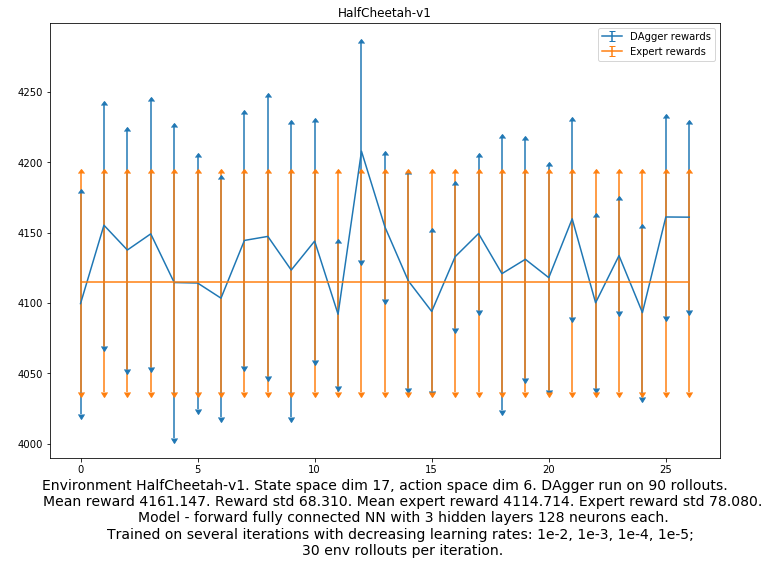

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(nrows=len(environments), ncols=1, figsize = (12, 8*len(environments)), sharex=True)
#
for envname in environments:
    x = range(int(len(results[envname]['returns'])/10))
    y,yerr = [], []
    for i in x:
        y.append(  np.mean(results[envname]['returns'][i*10:(i+1)*10]))
        yerr.append(np.std(results[envname]['returns'][i*10:(i+1)*10]))
    ax = axs #[environments.index(envname)]
    ax.errorbar(x, y, yerr=yerr, fmt='-',label = 'DAgger rewards', lolims=True, uplims=True )
    ax.errorbar(x,[np.mean(results[envname]['expert_returns'])]*len(x),
                [np.std(results[envname]['expert_returns'])]*len(x),
               label = 'Expert rewards',
               lolims=True, uplims=True)
    ax.set_title(envname)
    ax.set_xlabel('''Environment {}. State space dim {}, action space dim {}. DAgger run on {} rollouts.
        Mean reward {:.3f}. Reward std {:.3f}. Mean expert reward {:.3f}. Expert reward std {:.3f}.
        Model - forward fully connected NN with 3 hidden layers 128 neurons each.
        Trained on several iterations with decreasing learning rates: 1e-2, 1e-3, 1e-4, 1e-5; 
        30 env rollouts per iteration.
        '''.format(
        envname,
        state_shape,
        actions_shape,
        args.num_rollouts,
        np.mean(results[envname]['returns'][-20:]),
        np.std(results[envname]['returns'][-20:]),
        np.mean(results[envname]['expert_returns'][-20:]),
        np.std(results[envname]['expert_returns'][-20:])),
        fontsize = 14
           )
    plt.legend()


In [64]:
fig.savefig('DAgger_HalfCheetah-v1.png')

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots()
ax1.plot(returns, 'b-')
#ax1.set_xlabel('time (s)')
ax1.set_ylabel('error', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(returns, 'g')
ax2.set_ylabel('reward', color='g')
ax2.tick_params('y', colors='g')

fig.tight_layout()
plt.show()
